In [665]:
import dataclasses
import itertools
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

import embcomp as ec


def plot(df_or_seq):
    if isinstance(df_or_seq, pd.DataFrame):
        seq = [X.values for _, X in df_or_seq.groupby("label")]
    plt.gca().set_aspect("equal")
    for X in seq:
        plt.scatter(X[:, 0], X[:, 1], s=1)


def dataframe(generate_pts, labels: Iterable[str] = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    """Collects sequence of X into a labeled pd.DataFrame"""

    def wrapper(*args, **kwargs):
        dfs = []
        for label, result in zip(labels, generate_pts(*args, **kwargs)):
            if isinstance(result, tuple):
                label, X = result
            else:
                X = result

            dfs.append(pd.DataFrame(dict(x=X[:, 0], y=X[:, 1], label=label)))

        df = pd.concat(dfs)
        df.label = df.label.astype("category")
        return df

    return wrapper


Covariance2D = tuple[tuple[float, float], tuple[float, float]]

### Confusion 1

- Case: 5 equal sized groups, well separated
- Expected: no confusion

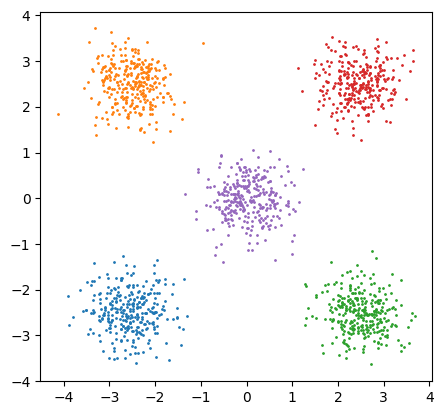

In [666]:
@dataframe
def case1(x: float = 2.5, cov: Covariance2D = ((0.2, 0), (0, 0.2)), size: int = 300):
    yield np.random.multivariate_normal((-x, -x), cov, size)
    yield np.random.multivariate_normal((-x, x), cov, size)
    yield np.random.multivariate_normal((x, -x), cov, size)
    yield np.random.multivariate_normal((x, x), cov, size)
    yield np.random.multivariate_normal((0, 0), cov, size)


plot(case1())

### Confusion 2

- Case: 5 equal sized groups, 2 mixed
- Expected: confusion with last two groups

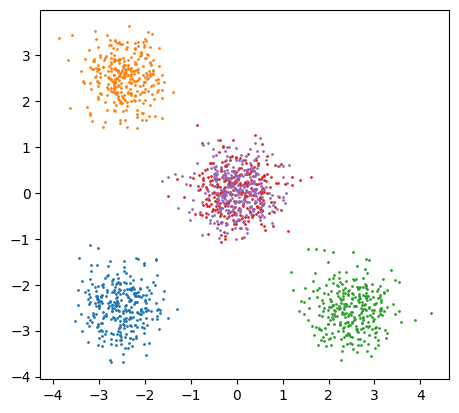

In [667]:
@dataframe
def case2(x: float = 2.5, cov: Covariance2D = ((0.2, 0), (0, 0.2)), size: int = 300):
    yield np.random.multivariate_normal((-x, -x), cov, size)
    yield np.random.multivariate_normal((-x, x), cov, size)
    yield np.random.multivariate_normal((x, -x), cov, size)
    yield np.random.multivariate_normal((0, 0), cov, size)
    yield np.random.multivariate_normal((0, 0), cov, size)


plot(case2())

### Confusion 3

- Case: 5 groups of various sizes, small group intermixed with larger
- Expected: smaller group should be confused with larger mixed group

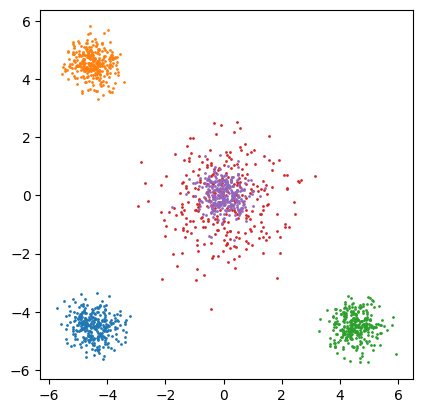

In [668]:
@dataframe
def case3(x: float = 4.5, cov: Covariance2D = ((0.2, 0), (0, 0.2)), size: int = 300):
    size_factor = 100
    cov_factor = 6
    cov = np.array(cov)

    yield np.random.multivariate_normal((-x, -x), cov, size)
    yield np.random.multivariate_normal((-x, x), cov, size)
    yield np.random.multivariate_normal((x, -x), cov, size)
    yield np.random.multivariate_normal((0, 0), cov * cov_factor, size)
    yield np.random.multivariate_normal((0, 0), cov, size)


plot(case3())

### Confusion 4

- Case: 5 groups of various sizes, small group intermixed with larger
- Expected: smaller group should be confused with larger mixed group

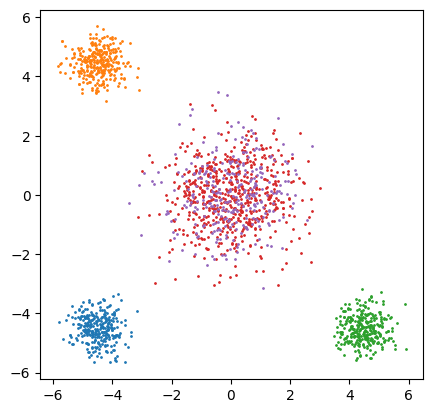

In [686]:
@dataframe
def case4(x: float = 4.5, cov: Covariance2D = ((0.2, 0), (0, 0.2)), size: int = 300):
    size_factor = 2
    cov_factor = 6
    cov = np.array(cov)

    yield np.random.multivariate_normal((-x, -x), cov, size)
    yield np.random.multivariate_normal((-x, x), cov, size)
    yield np.random.multivariate_normal((x, -x), cov, size)
    yield np.random.multivariate_normal((0, 0), cov * cov_factor, size * size_factor)
    yield np.random.multivariate_normal((0, 0), cov * cov_factor, size)


plot(case4())

### Confusion 5

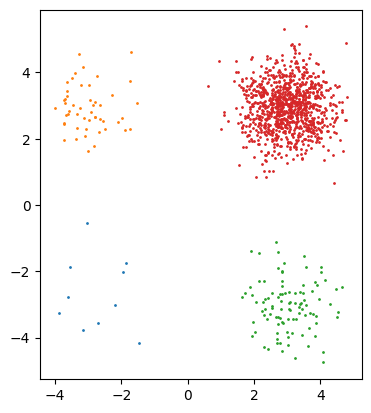

In [835]:
@dataframe
def case5(x: float = 3, cov: Covariance2D = ((0.5, 0), (0, 0.5))):
    yield np.random.multivariate_normal((-x, -x), cov, 10)
    yield np.random.multivariate_normal((-x, x), cov, 50)
    yield np.random.multivariate_normal((x, -x), cov, 100)
    yield np.random.multivariate_normal((x, x), cov, 1000)


plot(case5())

## Confusion 6

## Testing


In [961]:
import matplotlib as mpl
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import embcomp as ec


def plot_confusion(df, metrics):
    fig, (ax0, *axs) = plt.subplots(nrows=1, ncols=len(metrics) + 1, figsize=(12, 2))

    ax0.set_facecolor("black")
    ax0.tick_params(
        left=False, right=False, labelleft=False, labelbottom=False, bottom=False
    )

    for (_, data), color in zip(df.groupby("label"), jscatter.glasbey_dark):
        ax0.scatter("x", "y", data=data, color=color, s=1, alpha=0.5)

    sideax = make_axes_locatable(ax0).append_axes("left", size="20%", pad=0.1)
    sideax.set_xlabel("size")
    sideax.barh(
        df.label.cat.categories.values,
        df.label.value_counts(sort=False),
        color=jscatter.glasbey_dark[: len(df.label.cat.categories)],
        alpha=0.5,
    )

    for ax, maybe_func in zip(axs, metrics):
        if callable(maybe_func):
            func = maybe_func
        else:
            title, func = maybe_func
            ax.set_title(title)
        ax.set_facecolor("black")
        ax.tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )
        confusion = 1 - ec.metrics.rowise_cosine_similarity(
            func(df), np.eye(len(df.label.cat.categories))
        )

        sideax = make_axes_locatable(ax).append_axes("left", size="20%", pad=0.1)
        sideax.set_xlim([0, 1])
        sideax.set_xlabel("conf.")
        sideax.barh(
            confusion.index,
            confusion.values,
            color=jscatter.glasbey_dark[: len(confusion)],
            alpha=0.5,
        )

        norm, cmap = Normalize(0, 1), "viridis"
        fig.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax=ax,
            shrink=0.3,
            anchor=(0, 1),
        )
        ax.scatter(
            df["x"],
            df["y"],
            c=df["label"].map(confusion),
            s=1,
            cmap=cmap,
            alpha=0.5,
            norm=norm,
        )

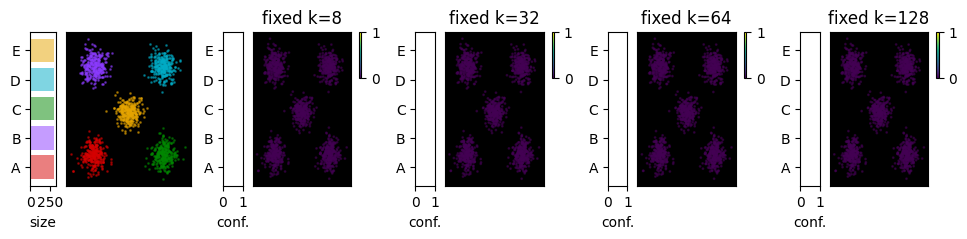

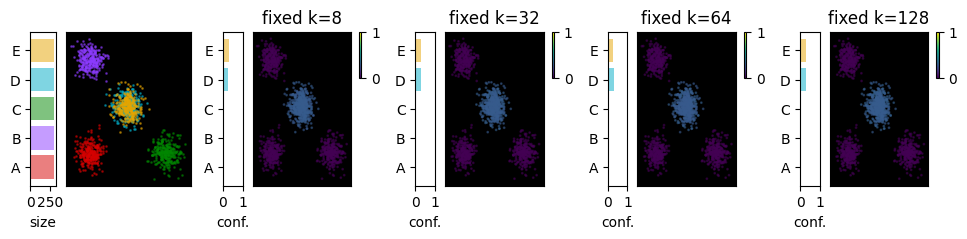

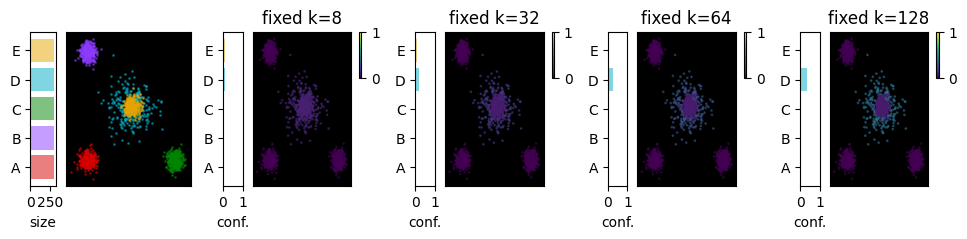

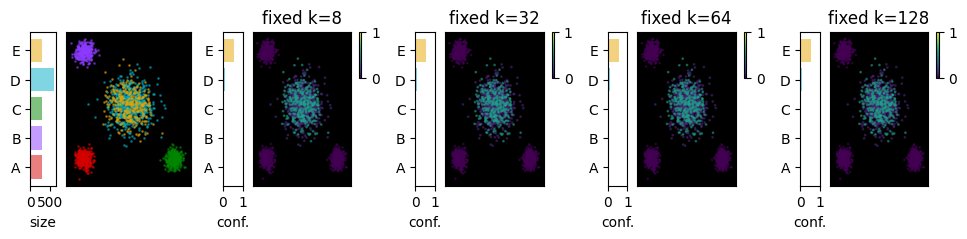

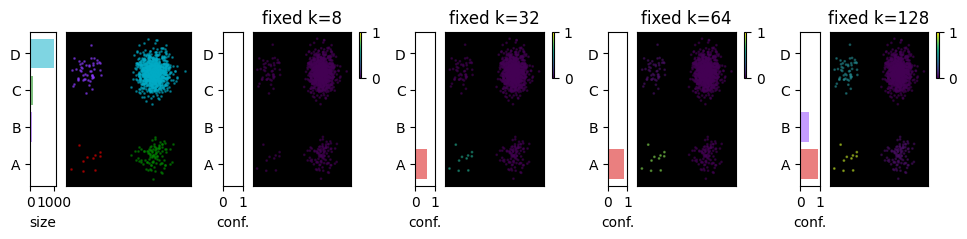

In [963]:
import functools


def example_fn(data: pd.DataFrame, k):
    nn = NearestNeighbors(n_neighbors=k).fit(data[["x", "y"]])
    knn_indices = nn.kneighbors(return_distance=False)
    counts = ec.metrics.count_neighbor_labels(knn_indices, data.label)
    index = pd.Series(data.label, name="label", dtype="category")
    df = pd.DataFrame(counts, index=index).groupby("label").sum()
    df.columns = index.cat.categories
    return df


def run(cases, metrics):
    for case in cases:
        plot_confusion(case(), metrics)

run(
    cases=[case1, case2, case3, case4, case5],
    metrics=[
        ("fixed k=8", functools.partial(example_fn, k=8)),
        ("fixed k=32", functools.partial(example_fn, k=32)),
        ("fixed k=64", functools.partial(example_fn, k=64)),
        ("fixed k=128", functools.partial(example_fn, k=128)),
    ],
)